In [1]:
using DataFrames, CSV
using JLD
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots
using Distributions

In [2]:
const GRB_ENV = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


In [3]:
G_max = 74.0 #max gradient, prevent nerve stimulation by limiting max gradient and slew rate. mT/m
SR_max = 50.0 #max slew rate mT/m/ms

dt = 0.5 #ms
Teps = 26.4 #time to echo ms
T90 = 5.3 #90 degree RF time ms
T180 = 4.3 #half of 180 degree RF time ms
lambda_null = 60 #ms
epsilion = 1e-4
GAMMA = (42.58*10^3) * 2 * pi;


TEmin = T180 + 2 * Teps
TEmax = 97.0
bval = 500.0;

In [4]:
Teps = trunc(Int,Teps/dt+0.5)
T90 = trunc(Int, T90/dt + 0.5)
T180 = trunc(Int, T180/dt/2 + 0.5)
TEmin = trunc(Int, TEmin/dt + 0.5)
TEmax = trunc(Int, TEmax/dt + 0.5)
lambda_null = lambda_null/dt;

In [5]:
#variable
TE = TEmax + 1
iter = 0

solve_time_all = []
obj_all = []
Gp_all = []
Gn_all = []
F_all = []

while true
    TE -= 1
    iter += 1
    Tdiff = TE-Teps
    TEH = trunc(Int, TE/2.0 + 0.5)
    
    Inv = -1.0* ones(TE)
    Inv[1:TEH] .= 1.0
    
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model, "MIPGap" => 1e-4,"OutputFlag" => 0);

    @variable(model, Gp[1:TE]>=0) #Gradient positive part before 180 pulse
    @variable(model, Gn[1:TE]>=0) #Gradient positive part after 180 pulse
    @variable(model, G_sign[1:TE], Bin) #Gradient sign (only positive or negative)
    @variable(model, F[1:TE]) #F value
    
    @objective(model, Max, sum(Gp[i]+Gn[i] for i=1:TE))
    
    @constraint(model, Gp_max_const[i in 1:TE], Gp[i] <= G_max*G_sign[i])
    @constraint(model, Gn_max_const[i in 1:TE], Gn[i] <= G_max*(1-G_sign[i]))
    @constraint(model, max_slew_const1[i in 2:TE], -SR_max*dt<= Gp[i]-Gp[i-1] <= SR_max*dt)
    @constraint(model, max_slew_const2[i in 2:TE], -SR_max*dt<= Gn[i]-Gn[i-1] <= SR_max*dt)
    @constraint(model, T90_const1[i in 1:T90], Gp[i] == 0.0)
    @constraint(model, T90_const2[i in 1:T90], Gn[i] == 0.0)
    
    @constraint(model, T180_const1[i in TEH-T180+1:TEH+T180], Gp[i] == 0.0)
    @constraint(model, TEPI_const1[i in Tdiff+1:TE], Gp[i] == 0.0)
    @constraint(model, T180_const2[i in TEH-T180+1:TEH+T180], Gn[i] == 0.0)
    @constraint(model, TEPI_const2[i in Tdiff+1:TE], Gn[i] == 0.0)

    @constraint(model, M0_const, sum(Inv[i]*(Gp[i]-Gn[i]) for i = 1:TE) == 0.0)
    @constraint(model, M1_const, sum(i*Inv[i]*(Gp[i]-Gn[i]) for i = 1:TE) == 0.0)
    
    @constraint(model, F_const1, F[1] == 0)
    @constraint(model, F_const2[i in 2:TE], F[i] == sum(Inv[j] * (Gp[j] - Gn[j]) for j=1:i)*0.001*0.001 *dt)

    push!(solve_time_all, @elapsed optimize!(model))
    push!(obj_all, objective_value(model))
    
    b = 0
    
    for i in 1:TE
        b = b + value.(F)[i]^2
    end
    
    b = b * GAMMA * GAMMA *0.001*dt
    
    @printf("TEH: %.2f, Tdiff: %.2f, TE: %.2f, bval: %.2f\n", TEH*dt, Tdiff*dt, TE*dt, b)

    push!(Gp_all, value.(Gp))
    push!(Gn_all, value.(Gn))
    push!(F_all, value.(F))

    if(b < bval)
        break
    end
    
    
end
    

TEH: 48.50, Tdiff: 70.50, TE: 97.00, bval: 1841.20
TEH: 48.50, Tdiff: 70.00, TE: 96.50, bval: 1453.19
TEH: 48.00, Tdiff: 69.50, TE: 96.00, bval: 1377.24
TEH: 48.00, Tdiff: 69.00, TE: 95.50, bval: 1677.74
TEH: 47.50, Tdiff: 68.50, TE: 95.00, bval: 1672.92
TEH: 47.50, Tdiff: 68.00, TE: 94.50, bval: 1619.61
TEH: 47.00, Tdiff: 67.50, TE: 94.00, bval: 1301.24
TEH: 47.00, Tdiff: 67.00, TE: 93.50, bval: 1527.90
TEH: 46.50, Tdiff: 66.50, TE: 93.00, bval: 1515.97
TEH: 46.50, Tdiff: 66.00, TE: 92.50, bval: 1240.55
TEH: 46.00, Tdiff: 65.50, TE: 92.00, bval: 1424.06
TEH: 46.00, Tdiff: 65.00, TE: 91.50, bval: 1412.64
TEH: 45.50, Tdiff: 64.50, TE: 91.00, bval: 1156.50
TEH: 45.50, Tdiff: 64.00, TE: 90.50, bval: 1321.09
TEH: 45.00, Tdiff: 63.50, TE: 90.00, bval: 1090.82
TEH: 45.00, Tdiff: 63.00, TE: 89.50, bval: 1254.32
TEH: 44.50, Tdiff: 62.50, TE: 89.00, bval: 1234.47
TEH: 44.50, Tdiff: 62.00, TE: 88.50, bval: 1193.42
TEH: 44.00, Tdiff: 61.50, TE: 88.00, bval: 1021.53
TEH: 44.00, Tdiff: 61.00, TE: 8

In [6]:
TEmin*dt

57.0

In [7]:
TEmax*dt

97.0

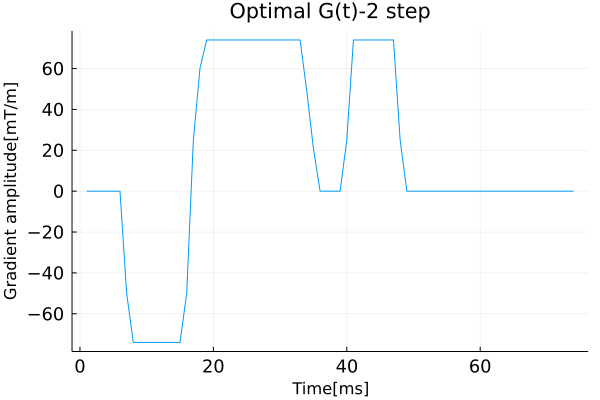

In [28]:
G_ap = Gp_all[47]-Gn_all[47]
G_ap2 = zeros(74)
for i in 1:74
    G_ap2[i] = G_ap[1+2*(i-1)]
end

plot(G_ap2,title="Optimal G(t)-2 step", xtickfontsize=12,ytickfontsize=12,label=nothing,xlabel="Time[ms]",ylabel="Gradient amplitude[mT/m]",fmt = :png)

In [9]:
T180

4

In [10]:
sum(solve_time_all)

168.2161292499999

In [11]:
TE*dt

73.5

In [12]:
Gp_all

48-element Vector{Any}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [14]:
G_ap2

148-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
 -25.0
 -49.999999999999645
   ⋮
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In [22]:
G_ap2

148-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
 -25.0
 -49.999999999999645
   ⋮
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0